# Тема: Введение в спортивный анализ данных, Exploration Data Analysis

In [101]:
import numpy as np
import pandas as pd

import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb

import warnings
warnings.simplefilter('ignore')

In [43]:
train = pd.read_csv('data/assignment1_data/train.csv')
test = pd.read_csv('data/assignment1_data/test.csv')

In [44]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [45]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 308.23 MB
Memory usage after optimization is: 154.30 MB
Decreased by 49.9%


In [46]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 306.70 MB
Memory usage after optimization is: 154.11 MB
Decreased by 49.8%


### Задание 1: Сделать базовый анализ данных: 
* вывести размерность датасетов, 
* посчитать базовые статистики, 
* выполнить анализ пропусков, 
* сделать выводы

In [47]:
stata = pd.DataFrame(columns=['train', 'test'])

In [48]:
def basic_analysis(data, data_name):
    
    stata.loc['Количество наблюдений', data_name] = data.shape[0]
    stata.loc['Количество признаков', data_name] = data.shape[1]
    
    dict_dtypes = {}
    for i in data.dtypes.unique():
        dict_dtypes[i] = 0
    for j in data.dtypes:
        dict_dtypes[j] += 1  
    for k, v in dict_dtypes.items():
        stata.loc[f'Признаков {k}', data_name] = v
        
    list_nan = 0
    for i in data.count():
        if i != data.shape[0]:
            list_nan += 1
    stata.loc[f'Признаков с NaN', data_name] = list_nan
    
    list_disc = 0
    list_cont = 0
    for i in data.columns:
        if data[i].dtype != object:
            if data[i].nunique() < 25:
                list_disc += 1
            else:
                list_cont += 1          
    stata.loc[f'Дискретных признаков', data_name] = list_disc
    stata.loc[f'Непрерывных признаков', data_name] = list_cont
    
    dict_num = {'единицы': 0, 'десятки': 0, 'прочее': 0}
    for i in data.columns:
        if data[i].dtype != object:
            num = len(str(round(abs(max(data[i])))))
            if num == 1:
                dict_num['единицы'] += 1
            elif num == 2:
                dict_num['десятки'] += 1
            else:
                dict_num['прочее'] += 1
    for k, v in dict_num.items():
        stata.loc[f'Масштаб признаков в {k}', data_name] = v

In [49]:
basic_analysis(data=train, data_name='train')
basic_analysis(data=test, data_name='test')

In [50]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.522699,-2.3978,7.8784,8.5635,12.780300,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.430500,2.0339,8.1267,8.7889,18.356001,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.604200,3.1417,-6.5213,8.2675,14.722200,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.034700,-1.2706,-2.9275,10.2922,17.969700,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.287600,-1.5121,3.9267,9.5031,17.997400,-8.8104


In [51]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.267500,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.711200,2.4669,4.3654,10.7200,15.472200,-8.719700
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.631599,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.576500,0.4773,-1.4852,9.8714,19.129299,-20.976000
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.253700,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.981300,2.1281,-7.1086,7.0618,19.895599,-23.179399
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.566000,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.187400,3.1656,3.9567,9.2295,13.016800,-4.210800
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.604800,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.554199,-0.2860,-5.1612,7.2882,13.926000,-9.184600


In [52]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679973,-1.627628,10.715126,6.796523,11.078255,-5.065340,5.408961,16.545988,0.284159,...,3.234436,7.438449,1.927833,3.331773,17.993811,-0.142087,2.303355,8.908224,15.870864,-3.326542
std,0.300653,3.039990,4.049967,2.640832,2.043276,1.623114,7.863115,0.866585,3.418009,3.332576,...,4.559854,3.023208,1.478388,3.991934,3.135113,1.429341,5.454274,0.921603,3.010892,10.437832
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562599,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852798
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064724,4.836800
max,1.000000,20.315001,10.376800,19.353001,13.188300,16.671400,17.251600,8.447700,27.691799,10.151300,...,18.440901,16.716499,8.402400,18.281799,27.928801,4.272900,18.321501,12.000400,26.079100,28.500700


In [53]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658732,-1.624240,10.707497,6.788238,11.076387,-5.050552,5.415207,16.529312,0.277133,7.569351,...,3.189724,7.458230,1.925958,3.322033,17.996922,-0.133656,2.290916,8.912555,15.869393,-3.246347
std,3.036675,4.040431,2.633820,2.052685,1.616426,7.869115,0.864669,3.424418,3.333328,1.231836,...,4.551188,3.025138,1.479932,3.995498,3.140603,1.429652,5.446252,0.920886,3.008664,10.398454
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457802
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391726,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292801,9.665500,11.003600,...,20.358999,16.716499,8.005000,17.632601,27.947800,4.545400,15.920700,12.275800,26.538401,27.907400


In [54]:
stata

,train,test
Количество наблюдений,200000,200000
Количество признаков,202,201
Признаков object,1,1
Признаков int8,1,NaN
Признаков float32,200,200
Признаков с NaN,0,0
Дискретных признаков,1,0
Непрерывных признаков,200,200
Масштаб признаков в единицы,30,31
Масштаб признаков в десятки,171,169


**Вывод:** 
- датасеты одинаковые по размеру (без учета целевой переменной в train)
- ID_code - порядковый признак, не несет смысловой нагрузки
- все числовые признаки относятся к непрерывным
- масштаб числовых признаков достаточно однородный (единицы и десятки)

### Задание 2: Сделать базовый анализ целевой переменной, сделать выводы

In [55]:
target_name = 'target'
cont_feature_name = list(train.select_dtypes(include=[np.float32]).columns)

In [56]:
train[target_name].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [57]:
disbalance = round(train[target_name].value_counts()[0] / train[target_name].value_counts()[1], 2)
disbalance

8.95

**Вывод:**
- целевая переменная состоит из 0 и 1 - задаче бинарной классификации.
- дисбаланс классов целевой переменной составляет 1:9, велика вероятность переобучения модели на примерах преобладающего класса. 

### Задание 3: Построить:
* распределение признаков в зависимости от значения целевой переменной 
* распределение признаков для обучающей и тестовой выборки 
* сделать выводы

(если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196)

In [128]:
test_feature_name = ['var_0', 'var_1', 'var_2', 'var_5', 'var_9', 'var_10', 'var_13', 'var_20', 'var_26',
                     'var_40', 'var_55', 'var_80', 'var_106', 'var_109', 'var_139', 'var_175', 'var_184', 'var_196']

# features = test_feature_name
features = cont_feature_name

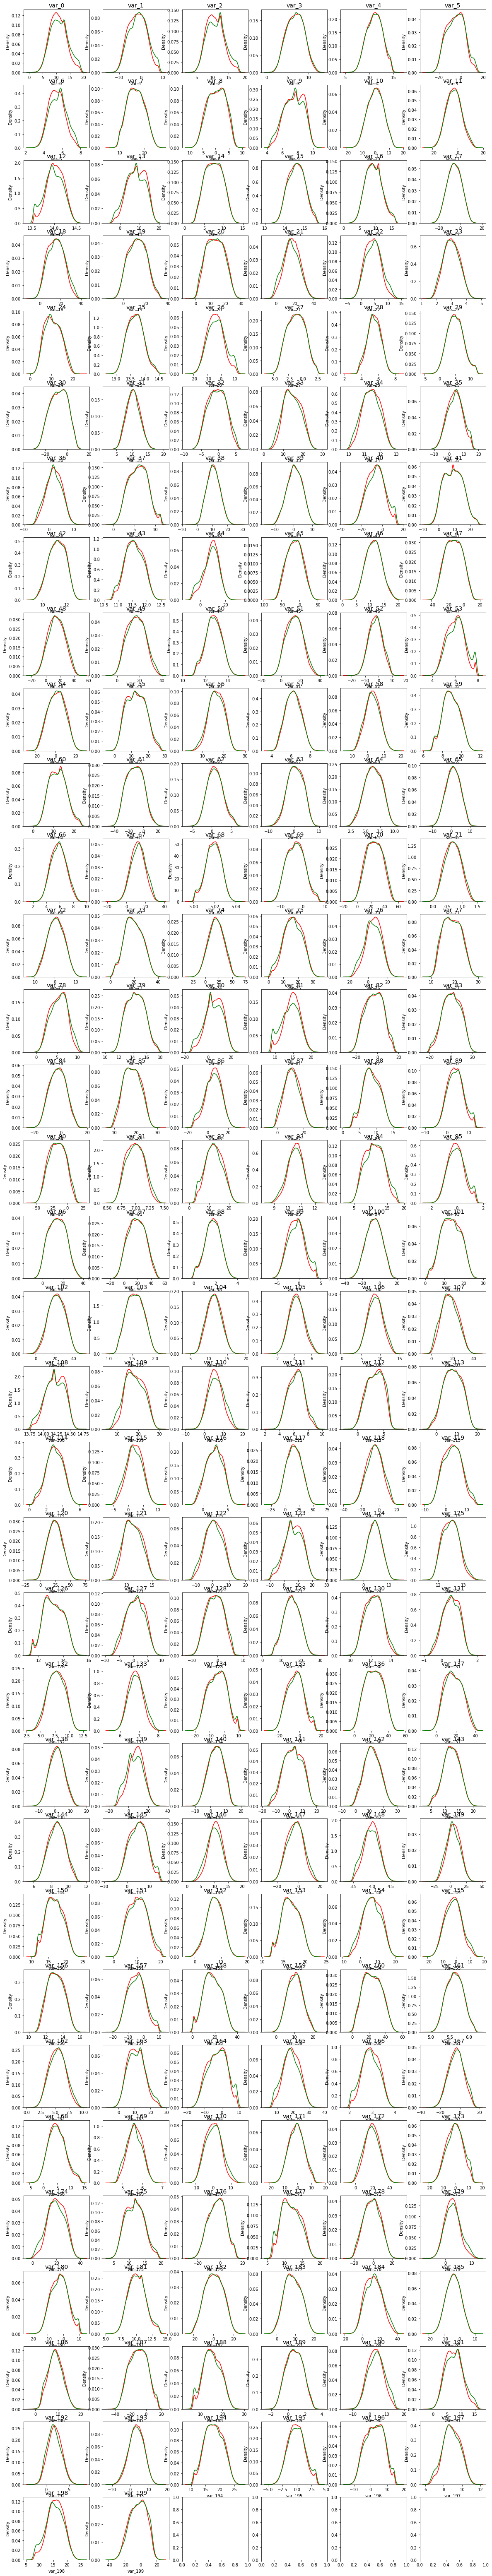

CPU times: user 2min 25s, sys: 1.27 s, total: 2min 26s
Wall time: 1min 38s


In [122]:
%%time

cols = 6
x = len(features)/cols
rows = round(x if int(x) == x else (x) + 0.5)

fig, axes = plt.subplots(rows, cols, figsize=(20, (20/cols)*rows))

for num, feature in enumerate(features):
    limit_bal_with_target = train[[feature, target_name]]
    limit_bal = limit_bal_with_target[feature]
    limit_bal_target_0 = limit_bal[limit_bal_with_target[target_name] == 0]
    limit_bal_target_1 = limit_bal[limit_bal_with_target[target_name] == 1]

    sns.kdeplot(limit_bal_target_0, ax=axes[num//cols, num%cols], label='0', color='r')
    sns.kdeplot(limit_bal_target_1, ax=axes[num//cols, num%cols], label='1', color='g')
    axes[num//cols, num%cols].set_title(feature, fontsize=14)

plt.show()

**Вывод:**
* Наблюдаются признаки, которые имеют различные распределения в зависимости от значения целевой переменной, что может помочь при построение модели, т.к. существует некоторая функциональная зависимость.

CPU times: user 4min 19s, sys: 1.51 s, total: 4min 21s
Wall time: 3min 1s


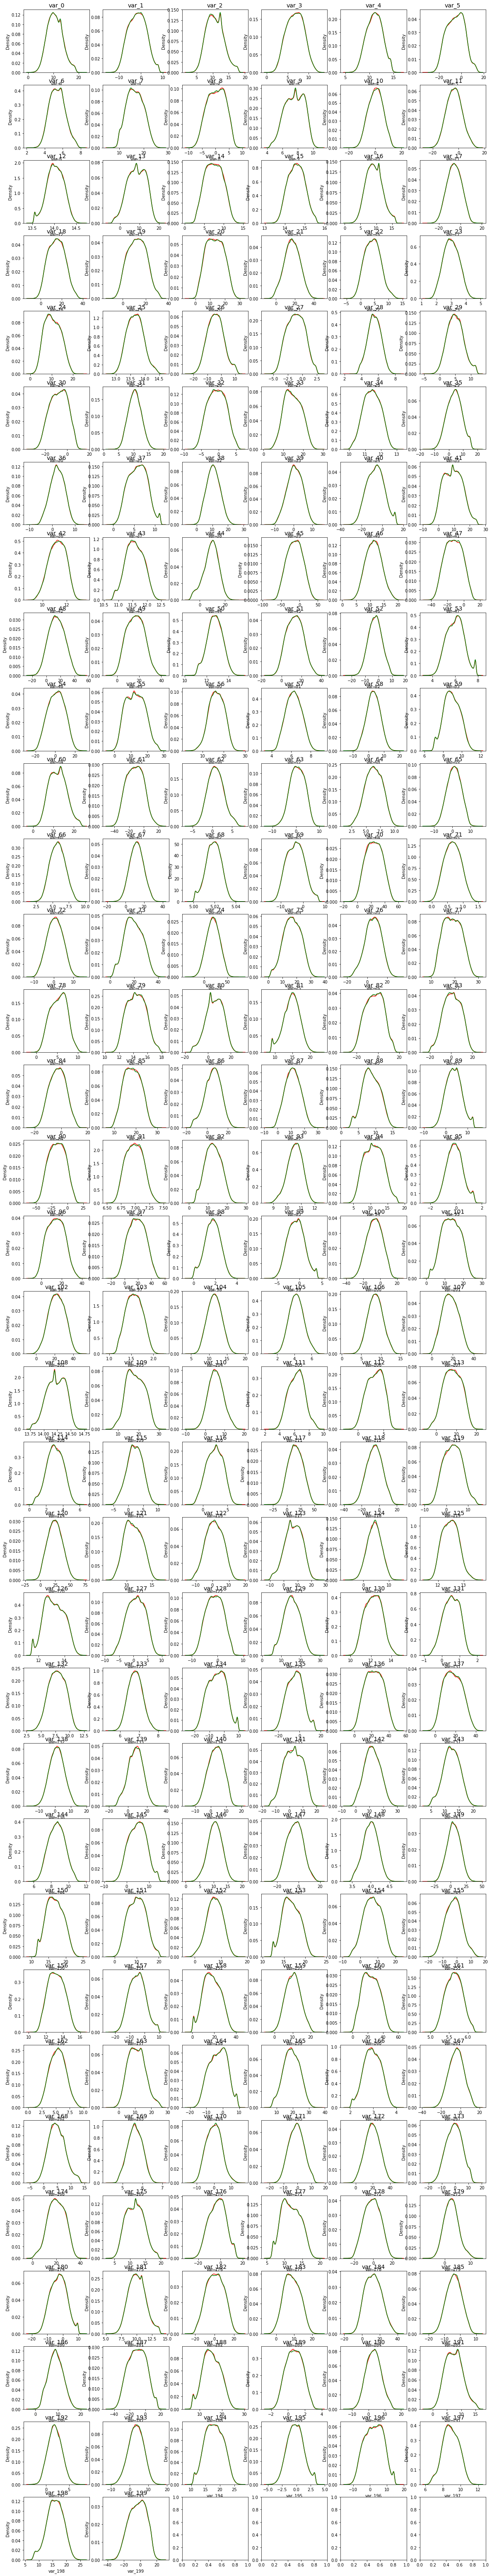

In [123]:
%%time

cols = 6
x = len(features)/cols
rows = round(x if int(x) == x else (x) + 0.5)

fig, axes = plt.subplots(rows, cols, figsize=(20, (20/cols)*rows)) 

for num, feature in enumerate(features):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//cols, num%cols], color="r", label="train")
        sns.kdeplot(test_data, ax=axes[num//cols, num%cols], color="g", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//cols, num%cols], color="blue", label="train")
    axes[num//cols, num%cols].set_title(feature, fontsize=14)

**Вывод:**
* рапределение признаков близко к нормальному
* на обеих выборках распределение признаков схоже

### Задание 4: Построить:
* распределение основных статистик признаков (среднее, стандартное отклонение) в разрезе целевой переменной, 
* распределение основных статистик обучающей и тестовой выборки, 
* сделать выводы

In [125]:
train_stat = pd.DataFrame(columns=['mean', 'std'])
train_stat['mean'] = train[features].mean()
train_stat['std'] = train[features].std()

test_stat = pd.DataFrame(columns=['mean', 'std'])
test_stat['mean'] = test[features].mean()
test_stat['std'] = test[features].std()

**распределение основных статистик признаков (среднее, стандартное отклонение) в разрезе целевой переменной**

Не понятно как можно совместить основные статистики по признакам и целевую переменную 

**распределение основных статистик обучающей и тестовой выборки**

CPU times: user 60.5 ms, sys: 6 µs, total: 60.5 ms
Wall time: 59.3 ms


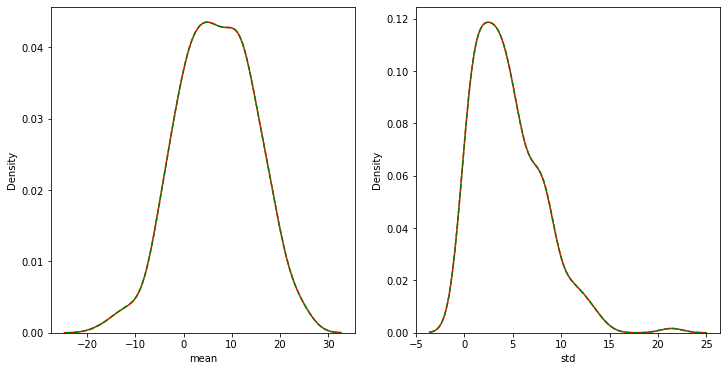

In [126]:
%%time

features = ['mean', 'std']

fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 
for num, feature in enumerate(features):
    train_stat_copy, test_stat_copy = train_stat[feature].copy(), test_stat[feature].copy()
    sns.kdeplot(train_stat_copy, ax=axes[num], color="red", label="train")
    sns.kdeplot(test_stat_copy, ax=axes[num], color="green", linestyle="dashed", label="test")

**Вывод:**
* распределения основных статистик обеих выборок идентичны.

### Задание 5: Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)

CPU times: user 15 s, sys: 124 ms, total: 15.1 s
Wall time: 15.1 s


<AxesSubplot:>

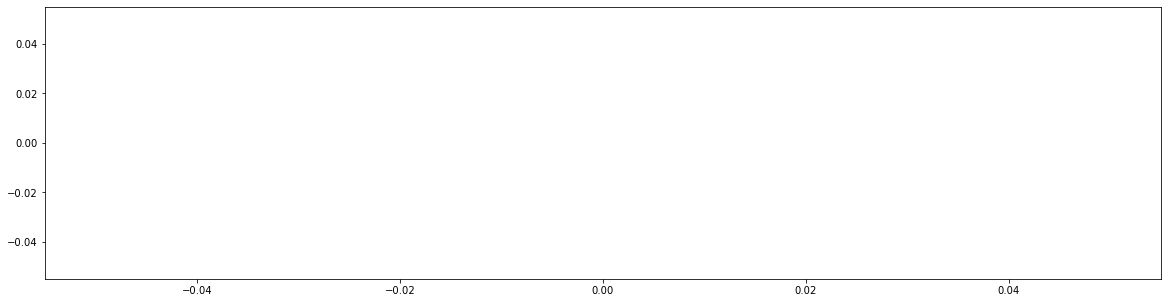

In [129]:
%%time

train_correlations = train[features].corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[(train_correlations != 1) & (train_correlations > 0.2)]

test_correlations = test[features].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[(test_correlations != 1) & (test_correlations > 0.2)]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

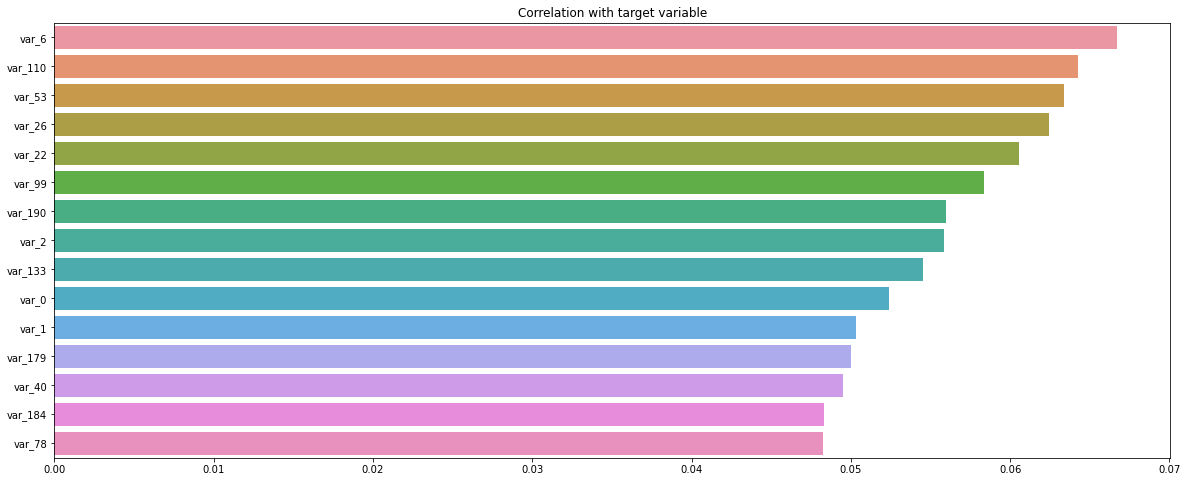

CPU times: user 7.66 s, sys: 35.8 ms, total: 7.69 s
Wall time: 7.7 s


In [130]:
%%time

top = 15
corr_with_target = train[features + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)
corr_with_target = corr_with_target.head(n=top)

plt.figure(figsize=(20, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Вывод:**
* корреляция между признаками не наблюдается, т.е. нет линейной зависимости
* корреляция признаков с целевой переменной тоже не высока

### Задание 6: Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [131]:
%%time

parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(train[features], train['target'])

CPU times: user 6min 18s, sys: 62.1 ms, total: 6min 18s
Wall time: 3min 16s


RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=2, random_state=27)

Text(0.5, 1.0, 'What are the top important features to start with?')

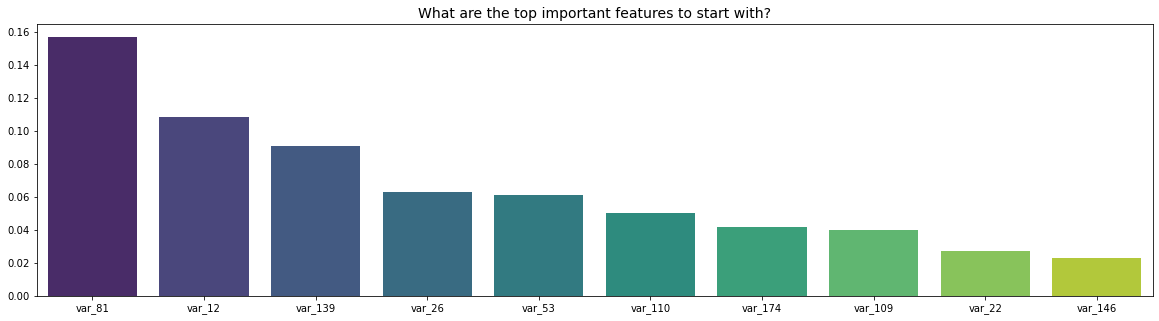

In [132]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train[features].columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

### Задание 7 (опция): Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

In [133]:
X_adv = pd.concat([
    train[features], test[features]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [135]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

[19:23:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:25:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:26:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV-score: 0.5116
CPU times: user 8min 42s, sys: 699 ms, total: 8min 43s
Wall time: 4min 21s


**Вывод:**
* метрика roc_auc близка к 0,5 - значит объекты выборок невозможно отличить друг от друга, данные из одного распределения.   